In [4]:
# MY SIMULATION 
import itertools
%matplotlib inline
import os
import random 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import vertex_model as model
# from vertex_model.run_select_nosaveinfo import run_simulation_INM, definecolors, run_simulation_no_INM
import itertools
import numpy as np
import matplotlib.pyplot as plt
import vertex_model as model
import vertex_model.initialisation as init
import vertex_model.characterization as crt
import vertex_model.save_data as save
from vertex_model.forces import TargetArea, Tension, Perimeter, Pressure
import os
import seaborn as sns
import warnings
import matplotlib.colors as colors
warnings.filterwarnings('ignore') #Don't show warnings
#from Gobal_Constant import dt, viscosity, t_G1, t_G2, t_S, A_c, J, pos_d, T1_eps, P, microns, time_hours, expansion_constant #file with necessary constants
from vertex_model.run_select import save_data
sns.set_style("whitegrid")
from scipy.spatial import Delaunay
import math
from scipy.spatial import ConvexHull

# Cell centres computation of a given mesh

In [5]:
def draw_edges(mesh, ax):
    w1 = mesh.vertices
    r = mesh.edges.rotate
    w2 =  mesh.vertices.take(r, 1) 
    w = w1-w2 # winding
    to_draw = mesh.edges.ids[(mesh.edges.ids < mesh.edges.reverse) | (np.abs(w[0])+np.abs(w[1]) > 0.1)]
    start, end = mesh.vertices.take(to_draw, 1), mesh.vertices.take(mesh.edges.next[to_draw], 1)
    n = np.empty(len(start[0]))
    n.fill(np.nan)
    x = np.dstack([start[0], end[0], n]).ravel()
    y = np.dstack([start[1], end[1], n]).ravel()
    return x, y

In [6]:
n_cell_up = 7
n_cell_across = 8

In [7]:
hex_centres = init.hexagonal_centres(n_cell_up, n_cell_across, 0.2, rand= np.random.RandomState())
mesh = init.toroidal_ic_mesh(hex_centres)
x, y = draw_edges(mesh, plt) 

In [8]:
def cell_vertices(mesh, id):   
    """
    Computes the coordinates of the vertices of a cell
    mesh: mesh object
    id: id of the cell whose vertices have to be computed 
    """ 
    cell_i = []
    for i in range(len(mesh.face_id_by_edge)):
        if mesh.face_id_by_edge[i] == id:
            cell_i.append(i)
    return cell_i
def centroid(vertexes_x, vertexes_y):   
     """
     Computes the centroid of a polygon
     vertexes_x: x coordinates of the vertices of a polygon 
     vertexes_y: y coordinates of the vertices of a polygon 
     """
     _len = len(vertexes_x)
     _x = sum(vertexes_x) / _len
     _y = sum(vertexes_y) / _len
     return(_x, _y)
def centroid_polygon(cell_area, vx, vy):
    n = len(vx)
    v_x = vx.tolist(); v_y = vy.tolist()
    v_x.append(v_x[0]); v_y.append(v_y[0])
    x = []; y = []
    for i in range(n):
        x = x + ((v_x[i]+v_x[i+1])*(v_x[i]*v_y[i+1]-v_x[i+1]*v_y[i]))
        y = y +  ((v_y[i]+v_y[i+1])*(v_x[i]*v_y[i+1]-v_x[i+1]*v_y[i]))
    x = x /(6*cell_area);     y = y /(6*cell_area); 
    return (x, y)
def mesh_centres(mesh):
    '''
    Compute the centres of the cells of a given mesh 
    '''
    centres_x =[]
    centres_y = [] 
    centres =np.zeros((mesh.n_face, 2))
    for i in range(mesh.n_face):       
       cell_i = cell_vertices(mesh, i) #vertices of the ith cell 
       area_i = mesh.area[i]
       if len(mesh.vertices[0][cell_i]) != 0:
        cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
        centres_x.append(cell_center_i[0])
        centres_y.append(cell_center_i[1])
        #centres.append(np.array([cell_center_i[0],cell_center_i[1] ]))
        centres[i, 0] = cell_center_i[0]
        centres[i, 1] = cell_center_i[1]
    return centres_x, centres_y, centres

def circumcenter(vertices):
    """ 
    Computes the circumcentre of a polygon
    vertices: coordinates of the vertices of the polygon whose circumcentre has to be computed 
    """
    hull = ConvexHull(vertices)
    edges = hull.points[hull.simplices]

    circumcenters = []
    for edge in edges:
        x1, y1 = edge[0]
        x2, y2 = edge[1]
        x3, y3 = edge[2]

        A = np.array([[x2 - x1, y2 - y1], [x3 - x1, y3 - y1]])
        b = 0.5 * np.array([[(x2 - x1) ** 2 + (y2 - y1) ** 2], [(x3 - x1) ** 2 + (y3 - y1) ** 2]])
        try:
            circumcenter = np.linalg.solve(A, b)
            circumcenter = [circumcenter[0][0] + x1, circumcenter[1][0] + y1]
            circumcenters.append(circumcenter)
        except np.linalg.LinAlgError:
            pass

    circumcenter = np.mean(circumcenters, axis=0)
    return circumcenter



## 1. Original cells and computed vertices and centres

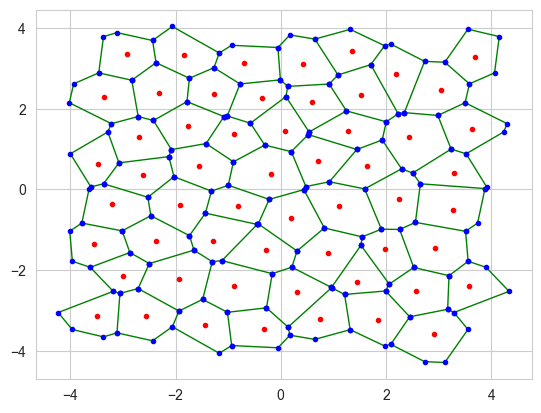

In [9]:
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='green')
b = mesh.boundary_faces
x_centers = []
y_centers = []
for i in range(mesh.n_face):
    cell_i = cell_vertices(mesh, i)
    plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='blue')
    cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
    plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='red')
    x_centers.append(cell_center_i[0])
    y_centers.append(cell_center_i[1])


## 3. Original vertices and cells and new centres. 

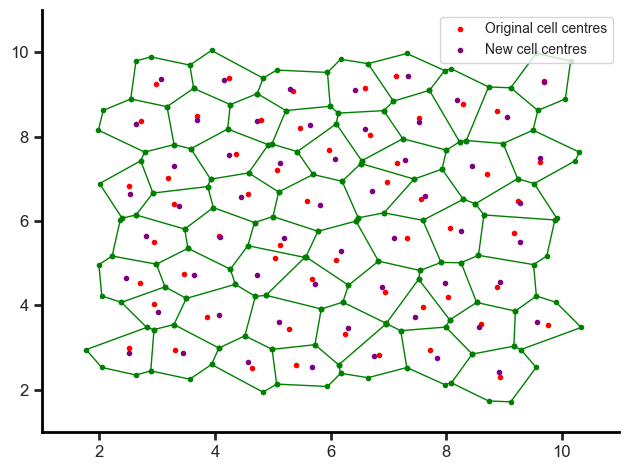

In [30]:
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='green')
plt.plot(hex_centres[0][:,0], hex_centres[0][:, 1], '.',color='red', label='Original cell centres', linewidth =1)
plt.plot(mesh.vertices[0], mesh.vertices[1], '.', color = 'green')
b = mesh.boundary_faces
x_centers = []
y_centers = []
for i in range(mesh.n_face):
    cell_i = cell_vertices(mesh, i)
    #plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='black')
    cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
    if i ==0: 
        plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple', label='New cell centres', linewidth =2)
    else:
            plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple', linewidth =2)

    x_centers.append(cell_center_i[0])
    y_centers.append(cell_center_i[1])
ax = plt.gca()

ax.spines['left'].set_linewidth(2)   # Left Y-axis
ax.spines['bottom'].set_linewidth(2) # Bottom X-axis
ax.spines['top'].set_linewidth(0) # Bottom X-axis
ax.spines['right'].set_linewidth(0) # Bottom X-axis

ax.spines['left'].set_color('black')   # Left Y-axis
ax.spines['bottom'].set_color('black') # Bottom X-axis

plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.tick_params(axis='both', which='major', labelsize=12)
plt.rcParams['ytick.labelsize']= 8
plt.rcParams['xtick.labelsize']= 8
plt.rcParams['legend.fontsize'] = 10
plt.tight_layout()
# plt.xlim(-600,600); plt.ylim(-600, 600)
plt.grid(False)
plt.legend(loc='upper right')
plt.xticks([-6, -4, -2, 0, 2, 4], [0, 2,  4,  6,  8, 10])
plt.yticks([-6, -4, -2, 0, 2, 4], [0, 2,  4,  6,  8, 10])
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()



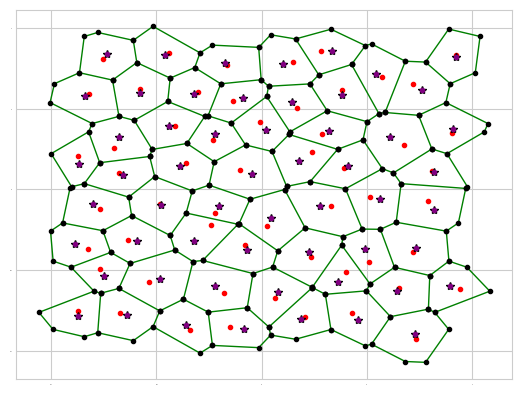

In [17]:
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='green')
plt.plot(hex_centres[0][:,0], hex_centres[0][:, 1], '.',color='red')
#plt.plot(mesh.vertices[0], mesh.vertices[1], '.', color = 'blue')
b = mesh.boundary_faces
x_centers = []
y_centers = []
my_centres = []
for i in range(mesh.n_face):
    cell_i = cell_vertices(mesh, i)
    plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='black')
    xc=np.mean(mesh.vertices[0][cell_i])
    yc = np.mean(mesh.vertices[1][cell_i])
    plt.plot(xc, yc, '*', color = 'black')
    cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
    plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple')
    x_centers.append(cell_center_i[0])
    y_centers.append(cell_center_i[1])
    my_centres.append([cell_center_i[0],cell_center_i[1]])

## 4. Circumcentres


In [28]:
# a = x[0:-1]
# b = y[0:-1]
# plt.plot(a,b, 'k-', linewidth=1.0, color='green')
# plt.plot(hex_centres[0][:,0], hex_centres[0][:, 1], '.',color='red')
# b = mesh.boundary_faces
# x_centers = []
# y_centers = []

# for i in range(mesh.n_face):
#     cell_i = cell_vertices(mesh, i)
#     cv = np.zeros((len(cell_i), 2))
#     for j in range(len(cell_i)):
#         v = cell_i[j]
#         cv[j][0] = mesh.vertices[0][v]
#         cv[j][1] = mesh.vertices[1][v]
#     cc = circumcenter(cv)
#     plt.plot(cc[0], cc[1], color='orange')
#     plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='blue')
#     cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
#     plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple')
#     x_centers.append(cell_center_i[0])
#     y_centers.append(cell_center_i[1])
    

## 5. Mesh generated with the centroids


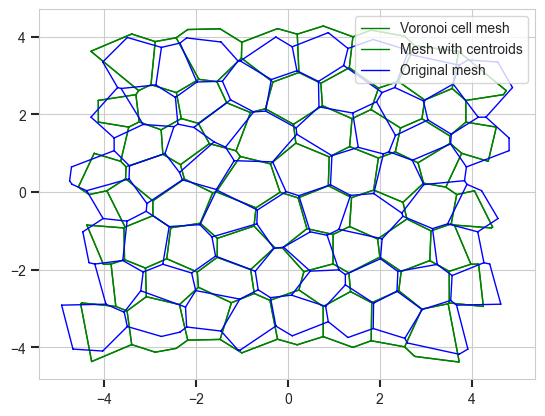

In [29]:
inicial = (np.array(my_centres), 8, 8)
my_mesh = init.toroidal_ic_mesh(inicial)
model.plotting._draw_edges(my_mesh, plt) 
x2, y2 = draw_edges(my_mesh, plt)
a2 = x2[0:-1]
b2 = y2[0:-1]
plt.plot(a2,b2, 'k-', linewidth=1.0, color='green', label = 'Mesh with centroids')
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='blue', label='Original mesh')
plt.legend()

In [32]:
def definecolors(cells):
    peach = '#eed5b7'
    light_blue ='#87cefa'
    pink = '#ffc0cb'
    light_green = '#98fb98'
    import matplotlib.colors as colors
    vv=sns.color_palette("hls", 10)
    v=[colors.rgb2hex(colorrgb) for colorrgb in vv]
    palette = np.array([light_green, pink,light_green,'g','r','g','m','c','',peach])
    palette = np.array([v[0],v[1],v[1], v[1],v[4],v[5],v[6],v[7],v[8],v[9],peach])
    colors = cells.properties['parent_group']
    return palette[colors]

In [33]:
simulations = [] # to store the different simulations for the different values of noise
noise= 0.5
ncellup =18
ncellacross = 18 #quiero comprobar como aumenta de tiempo ext cuando aumento mutant cells
ncells = ncellacross*ncellup
# ecad_cells_proportion = 0.04
# ecad_cells = int(ecad_cells_proportion* ncells)
# id_ecad_cells = random.sample(range(ncells), ecad_cells); print(id_ecad_cells)
mutant_cells_vec = np.arange(0, 0.5, 0.025) #different proportions of mutant cells in the mesh
#mutant_cells_vec=[0.18]
ecad_cells_vec = []
for m in mutant_cells_vec:
    history_10={}
    ecad_cells = int(m * ncells)
    

    # ecad_cells_vec.append(id_ecad_cells)
    #ids_Gamma0 = random.sample(range(1, 100), 10)
    simulations_same_mutant=[]
    for i in range(3):
        #run simulation with the choosen parameters
        id_ecad_cells = random.sample(range(ncells), ecad_cells); 
        rand =  np.random.RandomState() #random number to choose Lambda
        params = [K,G,L]  # K=x[0],G=x[1],L=x[2]
        hex_centres = init.hexagonal_centres(ncellup, ncellacross, noise, rand= np.random.RandomState())
        # create a voronoi mesh with those centres 
        mesh = init.toroidal_ic_mesh(hex_centres)
        cells = model.Cells(mesh,properties={'K':K,'Gamma':G,'P':0.0,'boundary_P':P,'Lambda':L, 'Lambda_boundary':0.5, 'A0':1.0})
        force = TargetArea() + Tension() + Perimeter() + Pressure()
        step = int(50/dt)
        history_init_10= run(basic_simulation(cells,force),step,int(1/dt)) 
        expansion_constant = 1
        cells = history_init_10[-1].copy()
        cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
        if id_ecad_cells != []:
            cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in id_ecad_cells])[1]] = 1
        cells.properties['Gamma']= np.array([G,0])[cells.properties['parent_group']]
        cells.properties['Lambda']= np.array([L,Lambda_0])[cells.properties['parent_group']]
        force = TargetArea() + Tension() + Perimeter() + Pressure()
        N_Step = math.floor(t_end/dt)
        history_10[i]= run(basic_simulation(cells,force),N_Step,.010/dt) 
        #save_data(i,history_10[i],'cells10')
        simulations_same_mutant.append(history_10[i])
        save.save_simulation(i, history_10[i], m,id_ecad_cells,"8sep", ncellacross, noise)
        print(f'{m} mutant cells, sim number {i}')

    simulations.append(simulations_same_mutant)  


0.0 mutant cells, sim number 0
0.0 mutant cells, sim number 1
0.0 mutant cells, sim number 2
0.025 mutant cells, sim number 0
0.025 mutant cells, sim number 1
0.025 mutant cells, sim number 2
0.05 mutant cells, sim number 0
0.05 mutant cells, sim number 1
0.05 mutant cells, sim number 2
0.07500000000000001 mutant cells, sim number 0
0.07500000000000001 mutant cells, sim number 1
0.07500000000000001 mutant cells, sim number 2
0.1 mutant cells, sim number 0
0.1 mutant cells, sim number 1
0.1 mutant cells, sim number 2
0.125 mutant cells, sim number 0
0.125 mutant cells, sim number 1
0.125 mutant cells, sim number 2
0.15000000000000002 mutant cells, sim number 0
0.15000000000000002 mutant cells, sim number 1
0.15000000000000002 mutant cells, sim number 2
0.17500000000000002 mutant cells, sim number 0
0.17500000000000002 mutant cells, sim number 1
0.17500000000000002 mutant cells, sim number 2
0.2 mutant cells, sim number 0
0.2 mutant cells, sim number 1
0.2 mutant cells, sim number 2
0.22

MemoryError: 

In [17]:
## Extrusion Time 
def t_extrusion(simulation, id_ecad_cells): 
    t = 0
    for time_step in simulation:
        extrused_cells = 0
        t = t+1
        area = time_step.mesh.area
        for a in area:
            if a == 0:
                extrused_cells= extrused_cells+1
        if extrused_cells == len(id_ecad_cells): 
            break
    return t

[369, 4000, 4000, 3222, 4000, 4000, 4000, 4000, 4000, 3087, 4000, 4000, 3450, 4000, 4000, 3493]
[[180, 55, 53, 261, 200, 243, 229, 298, 299, 308, 156, 134, 102, 146, 160, 79, 25, 106, 267, 59, 319, 259, 125, 89, 107, 43, 172, 104, 207, 132, 68, 116], [115, 255, 216, 206, 300, 79, 77, 25, 66, 121, 219, 109, 227, 224, 138, 280, 276, 191, 65, 293, 281, 158, 182, 17, 238, 161, 256, 157, 286, 12, 233, 167, 20, 98, 80, 55, 48, 168, 56, 314], [141, 35, 160, 4, 202, 265, 270, 167, 26, 121, 223, 244, 109, 197, 267, 113, 24, 215, 287, 143, 115, 92, 212, 318, 112, 286, 58, 172, 235, 5, 250, 183, 9, 149, 213, 158, 271, 138, 218, 199, 311, 314, 168, 285, 130, 0, 207, 180], [40, 10, 91, 293, 162, 50, 320, 254, 121, 2, 261, 281, 296, 236, 70, 49, 172, 174, 73, 152, 87, 213, 99, 265, 136, 36, 159, 198, 109, 283, 4, 178, 225, 218, 274, 294, 310, 249, 305, 37, 89, 169, 6, 131, 97, 295, 53, 112, 170, 233, 217, 241, 222, 78, 7, 113], [235, 292, 147, 296, 131, 184, 209, 242, 28, 77, 164, 3, 244, 101, 38, 1

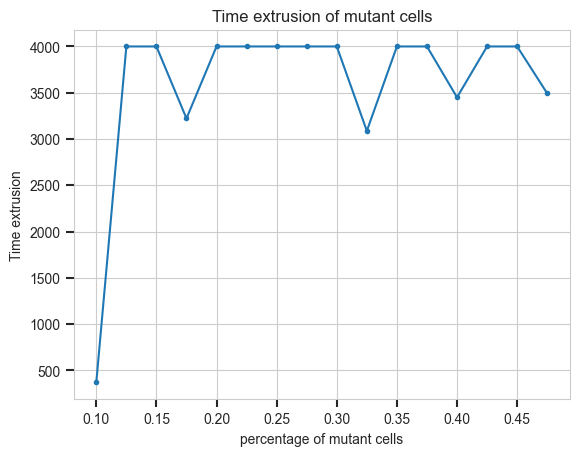

In [21]:

time_ext = []; 
for i, sim in enumerate(simulations):
    time_ext.append(t_extrusion(sim[0],ecad_cells_vec[i]))
plt.plot(mutant_cells_vec, time_ext, '.-'); plt.title('Time extrusion of mutant cells')
plt.xlabel('percentage of mutant cells'); plt.ylabel('Time extrusion')
print(time_ext)

print(ecad_cells_vec)


[0.3304947829349228, 0.33777476139383444, 0.33567665000843583, 0.33383992754089553, 0.33061119149014717, 0.347320968739442, 0.3311353237105326, 0.35781176092967876, 0.3584886131489876, 0.3514629495970712, 0.3545023044917093, 0.36520267812656726, 0.3476928346128024, 0.34576363896892653, 0.3546189263801339, 0.36191303460191604]


Text(0.5, 0, 'Percentage of mutant cells')

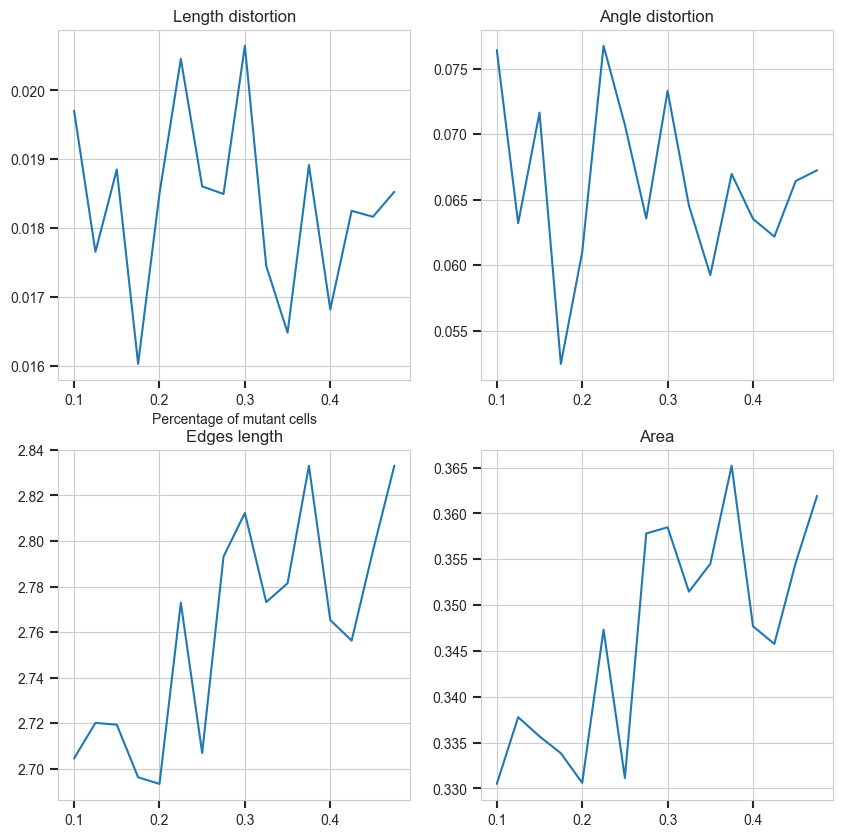

In [22]:
## Characterization of the final mesh of each simulation 
area = []
length_distortion = []
angle_distortion = []
edges_length = []
for i in range(len(simulations)):
    last_mesh_i = simulations[i][0][-1].mesh
    centres_x, centres_y, centres = mesh_centres(last_mesh_i)
    tri = Delaunay(centres)
    triangles = centres[tri.simplices]
    non_obtuse, non_obtuse_indices, obtuse, obtuse_indices = crt.triangle_sieve(triangles, np.pi / 10, np.pi - (np.pi / 10))
    trisieve = tri.simplices[non_obtuse_indices]
    #plt.triplot(centres[:,0], centres[:,1], trisieve)
    length_distortion.append(np.mean(crt.length_distortion(non_obtuse)))
    angle_distortion.append(np.mean(crt.angle_distortion(non_obtuse)))
    edges_length.append(crt.mean_perimeter(non_obtuse))
    a, std = crt.mean_area_triangles(non_obtuse)
    first_mesh_i = simulations[i][0][0].mesh
    centres_x_first, centres_y_first, centres_first = mesh_centres(last_mesh_i)
    tri_first = Delaunay(centres_first)
    triangles_first = centres_first[tri_first.simplices]
    non_obtuse_frist, non_obtuse_indices_first, obtuse_first, obtuse_indices_first = crt.triangle_sieve(triangles_first, np.pi / 10, np.pi - (np.pi / 10))
    trisieve_first = tri_first.simplices[non_obtuse_indices_first]
   
    area.append(a)
print(area)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(mutant_cells_vec, length_distortion, label ='Length distortion')
axs[0][0].set_title('Length distortion'); axs[0][0].set_xlabel('Percentage of mutant cells')

axs[0][1].plot(mutant_cells_vec, angle_distortion, label = 'Angle distortion')
axs[0][1].set_title('Angle distortion'); axs[0][0].set_xlabel('Percentage of mutant cells')

axs[1][0].plot(mutant_cells_vec, edges_length); axs[1][0].set_title('Edges length'); axs[0][0].set_xlabel('Percentage of mutant cells')

axs[1][1].plot(mutant_cells_vec, area); axs[1][1].set_title('Area'); axs[0][0].set_xlabel('Percentage of mutant cells')



# Evolution of the mesh during all time steps of the simulation

In [19]:
area_vec = []
length_distortion_vec = []
angle_distortion_vec = []
edges_length_vec = []
j = 0#NUMBER OF THE SIMULATION WE AER STUDYING
sim = simulations[j]
r = len(sim[0])
r = time_ext[j] +50
t = int(r/10)
t=t_end
print(r)
i = 0
while i < r: 
    mesh_i = sim[0][i].mesh
    centres_x, centres_y, centres = mesh_centres(mesh_i)
    tri = Delaunay(centres)
    triangles = centres[tri.simplices]
    non_obtuse, non_obtuse_indices, obtuse, obtuse_indices = crt.triangle_sieve(triangles, np.pi / 10, np.pi - (np.pi / 10))
    trisieve = tri.simplices[non_obtuse_indices]
    #plt.triplot(centres[:,0], centres[:,1], trisieve)
    length_distortion_vec.append(np.mean(crt.length_distortion(non_obtuse)))
    angle_distortion_vec.append(np.mean(crt.angle_distortion(non_obtuse)))
    edges_length_vec.append(crt.mean_perimeter(non_obtuse))
    a, std = crt.mean_area_triangles(non_obtuse)
    area_vec.append(a)
    i = i+1
print(len(area_vec))


183
183


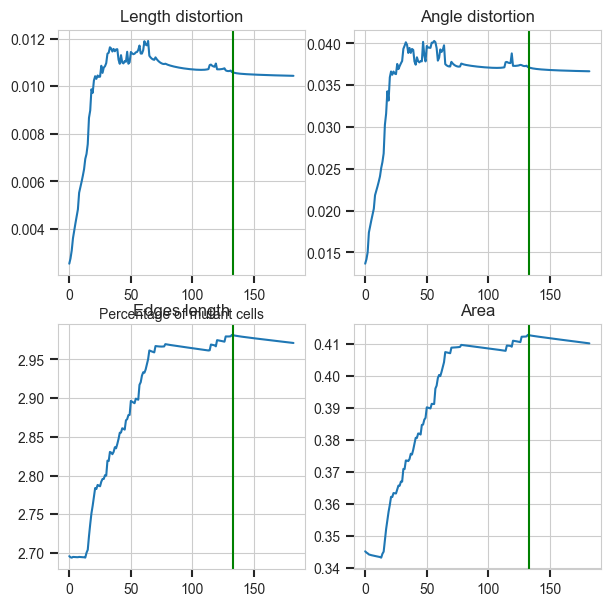

In [20]:
t = np.arange(0,3000, 1)
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
stop = time_ext[0] + 50
j =0
axs[0][0].plot(t[0:stop], length_distortion_vec[0:stop], label ='Length distortion')
axs[0][0].axvline(x=time_ext[0], color='green')
axs[0][0].set_title('Length distortion'); axs[0][0].set_xlabel('Percentage of mutant cells')

axs[0][1].plot(t[0:stop], angle_distortion_vec[0:stop], label = 'Angle distortion')
axs[0][1].axvline(x=time_ext[j], color='green')
axs[0][1].set_title('Angle distortion'); axs[0][0].set_xlabel('Percentage of mutant cells')

axs[1][0].plot(t[0:stop], edges_length_vec[0:stop]); axs[1][0].set_title('Edges length'); axs[0][0].set_xlabel('Percentage of mutant cells')
axs[1][0].axvline(x=time_ext[j], color='green')

axs[1][1].plot(t[0:stop], area_vec[0:stop]); axs[1][1].set_title('Area'); axs[0][0].set_xlabel('Percentage of mutant cells')
axs[1][1].axvline(x=time_ext[j], color='green')


In [ ]:
i=0
hh = simulations[i][0]
for cells in hh:
    #ids_nofronter = [1,15,30,6,98, 23,42,56,68,71]
    #cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
    #cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in ids_nofronter])[1]] = 1
    cells.properties['color'] = definecolors(cells)
    cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
    #ids_Gamma0 = [1,15,30,6,98, 23,42,56,68,71]
    #cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in ids_Gamma0])[1]] = 1
# definition of the frame for the interactive video
history_10_plot = hh[0:600]#+history1
fig=plt.figure()
fig.set_size_inches(6,6);
ax = fig.gca()
# initialization function: plot the background of each frame
def init_fig():
    ax = plt.figure();
    return (ax,)
# animation function. This is called sequentially
def animate_fig(i):
    cells_array=history_10_plot
    v_max = np.max((np.max(cells_array[-1].mesh.vertices), np.max(cells_array[0].mesh.vertices)))
    size = 2.0*v_max
    cells= history_10_plot[i]
    return model.draw(cells,ax,size)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,animate_fig, init_func=init_fig,
                               frames=(len(history_10_plot)))
HTML(anim.to_html5_video())

# Shape index

time steps when a cell is extruded: 

In [21]:
k = 0
ecad_k = ecad_cells_vec[k] # indices de las celulas mutantes de la simulacion k 
sim_k = simulations[k]
# tengo que mirar TODOS los time steps,no me vale avanzar de 20 en 20 como antes
t=time_ext[k] 
print(t)
cell_out_all = []
for id in ecad_k: 
    for i in range(t):
        mesh_i = sim_k[0][i].mesh
        area_i = mesh_i.area
        if area_i[id]==0:
           
            cell_out_all.append(i)
            break

133


In [22]:
cell_out_all.count(27)

1

In [23]:
k = 0
ecad_k = ecad_cells_vec[k] # indices de las celulas mutantes de la simulacion k 
sim_k = simulations[k]
# tengo que mirar TODOS los time steps,no me vale avanzar de 20 en 20 como antes
t=time_ext[k] 
print(t)
cell_out = []
for id in ecad_k: 
    for i in range(t):
        mesh_i = sim_k[0][i].mesh
        area_i = mesh_i.area
        if area_i[id]==0:
            if i not in cell_out:
                cell_out.append(i)
                break

print(ecad_k)

133
[283, 313, 295, 226, 124, 3, 176, 126, 227, 22, 132, 232, 74, 130, 11, 200, 198, 103, 85, 284, 157, 233, 187, 262, 220, 280, 49, 146, 168, 13, 265, 109, 70, 203, 4, 255, 28, 108, 182, 286, 292, 20, 133, 307, 113, 245, 71, 322, 35, 208, 211, 274, 55, 44, 175, 289, 120, 205]


In [24]:
hhh = []
for elem in cell_out: 
    hhh.append(3.75)

183
[3.726650240165726, 3.73207209408482, 3.7392159014297497, 3.745659174677936, 3.7513624313570944, 3.756575320071003, 3.761599526696812, 3.7670900767349784, 3.770149869103813, 3.773924474234268, 3.7780633331627267, 3.7827045960701096, 3.7881933400936427, 3.7939913696481433, 3.7995057899155555, 3.8067392962644493, 3.8141918545638345, 3.8149951392153634, 3.8144963244201446, 3.812385591488017, 3.8107529956632322, 3.8063570044283654, 3.803752495958779, 3.8029912995574353, 3.8021530824105674, 3.8032769414918763, 3.8050640798873183, 3.80312600319041, 3.804171711928688, 3.804431935948612, 3.8054401850230586, 3.8050468050933994, 3.804542804977999, 3.802149474739652, 3.801012026417517, 3.8012216741751197, 3.799160181246871, 3.797421886740202, 3.7979387781658285, 3.7975515310001904, 3.797204401731754, 3.7950810189282254, 3.800753708551933, 3.7929422705023246, 3.793821708612656, 3.796744140401716, 3.795096396272091, 3.795860281496627, 3.7925322148855876, 3.795061979908279, 3.7904765950985766, 3

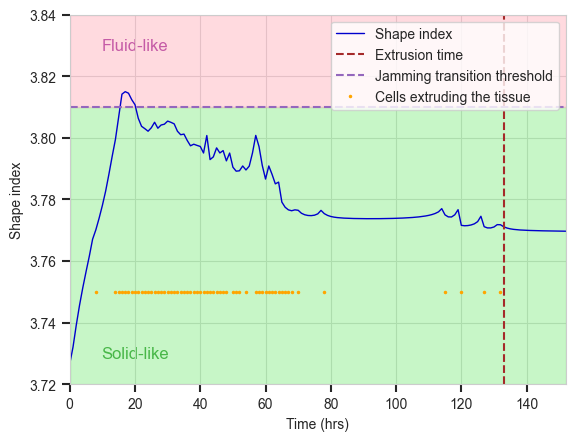

In [26]:
shape_indices = []
k = 0# number of the simulation
sim = simulations[k]
r = len(sim[0])
t = int(r/10)
l = time_ext[k]+50

print(l)
t=time_ext[k] +20

for i in range(t): #bucle por todos los time steps 

# for i in [16, 17, 18]:
    mesh_i = sim[0][i].mesh
    index_shape = []
    for j in range(len(mesh_i.area)): # bucle por cada area de cada celula en un time step 
        l = mesh_i.perimeter[j]
        a = mesh_i.area[j]
        if ((a != 0) and (l !=0)):
            si = l/np.sqrt(a)
            if not np.isnan(si): 
                

                index_shape.append(si)
        
    shape_indices.append(np.mean(index_shape))
    # if i == 17: 
    #     for ind, si in enumerate(index_shape):
    #         if np.isnan(si):
    #             print(ind)
# plt.axvline(time_ext[j])
fig, ax = plt.subplots()
xvec = range(t)
ax.plot(xvec, shape_indices, label='Shape index', color = 'mediumblue', linewidth =1)
ax.axvline(x = time_ext[k], color = 'brown', label = 'Extrusion time', linestyle = 'dashed')
ax.axhline(y = 3.81, color = 'tab:purple',linestyle = 'dashed',  label = 'Jamming transition threshold')
ymax = 3.84
line_y = 3.81; y_min = ax.get_ylim()[0]; y_max = ax.get_ylim()[1]
ax.axhspan(3.7, line_y,color = 'lightgreen', alpha=0.5)
ax.axhspan(line_y, ymax, color='lightpink', alpha=0.5)
ax.text(20, 3.73, 'Solid-like', fontsize=12, color='green', ha='center', va='center', zorder=-1)
ax.text(20, 3.83, 'Fluid-like', fontsize=12, color='darkmagenta', ha='center', va='center', zorder=-1)
ax.plot(cell_out, hhh, '.', markersize = 3, color = 'orange', label='Cells extruding the tissue')
c = [12, 13, 14, 15, 22, 23]; hh=[3.75,3.75,3.75,3.75,3.75,3.75]
# ax.plot(c,hh, '.', markersize = 5, color = 'orange')
ax.set_ylim(3.72, ymax ); ax.set_xlim(0,xvec[-1])

plt.legend(loc = 'upper right'); plt.ylabel('Shape index'); plt.xlabel('Time (hrs)')
print(shape_indices)

56

In [27]:
root= r'C:\Users\natal\OneDrive\Documentos\MASTER\TFM\Simulations\ShapeIndex'
folder = '0.15_0.18'
path_folder = os.path.join(root, folder)
if not os.path.exists(path_folder):
        os.makedirs(path_folder)
ext_t = []; ext_t.append(time_ext[k])
file_si = os.path.join(path_folder, 'shape_index.txt')
np.savetxt(file_si, shape_indices, delimiter=',')
file_et = os.path.join(path_folder, 'extrusion_time.txt')
np.savetxt(file_et, ext_t, delimiter=',')
file_co = os.path.join(path_folder, 'cells_out.txt')
np.savetxt(file_co, cell_out, delimiter=',')
file_a = os.path.join(path_folder, 'area.txt')
np.savetxt(file_a, area_vec, delimiter=',')
file_e = os.path.join(path_folder, 'edges.txt')
np.savetxt(file_e, edges_length_vec, delimiter=',')
file_ad = os.path.join(path_folder, 'angle_distortion.txt')
np.savetxt(file_ad, angle_distortion_vec, delimiter=',')
file_ld = os.path.join(path_folder, 'length_distortion.txt')
np.savetxt(file_ld, length_distortion_vec, delimiter=',')


In [ ]:
print(y_max)

In [ ]:
mutant_cells_vec[8]

# Hexagon distortion

### Study the hexagon distortion along the time of the simulation to check that when the mutant cells start to abandone the tissue, the latter is more distorted than before 

In [ ]:
## area of the regular hexagon ---> area of the first mesh cells, where all are regular 
i = 0 # number of the simulation we want to study 
mesh_0 = simulations[i][0][0].mesh # initial mesh of the simulation
areas = []
dist_area_hex =[]; dist_perimeter_hex = []
for j in range(len(simulations[i][0])): 
    mesh_j = simulations[i][0][j].mesh
    area_ratio = np.mean(mesh_j.area)/np.mean(mesh_0.area)
    areas.append(np.mean(mesh_j.area))
    perim_ratio = np.mean(mesh_j.perimeter)/np.mean(mesh_0.perimeter)
    dist_area_hex.append(area_ratio)
    dist_perimeter_hex.append(perim_ratio)
plt.plot(range(len(simulations[i][0])), dist_area_hex)
plt.plot(range(len(simulations[i][0])), dist_perimeter_hex)



In [ ]:
print(areas)

In [ ]:
def mean_area_mesh(mesh):
    ## to calculate the mean of the cell area of a mesh 
    ## but getting rid of the cells that have been removed from the tissue
    areas = mesh.area
    areas_non_zero = []
    for a in areas: 
        if a !=0:
            areas_non_zero.append(a)
    return np.mean(areas_non_zero)


In [ ]:
def mean_perimeter_mesh(mesh):
    ## to calculate the mean of the cell area of a mesh 
    ## but getting rid of the cells that have been removed from the tissue
    perimeter = mesh.perimeter
    perimeter_non_zero = []
    for a in perimeter: 
        if a !=0:
            perimeter_non_zero.append(a)
    return np.mean(perimeter_non_zero)

In [ ]:
i = 0 # number of the simulation we want to study 
areas = []; perimeters = []
for j in range(stop): 
    mesh_j = simulations[i][0][j].mesh
    areas.append(mean_area_mesh(mesh_j))
    perimeters.append(mean_perimeter_mesh(mesh_j))
#### PLOT results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(stop), areas, label = 'Mean areas')
axs[1].plot(range(stop), perimeters, label = 'Mean perimeters',color='green' )
axs[0].axvline(x = time_ext[i], color = 'purple', label = 'Time extrusion', linestyle = "dashed"); axs[0].legend()
axs[1].axvline(x = time_ext[i], color = 'purple', label = 'Time extrusion',linestyle = "dashed"); axs[1].legend()
axs[0].set_title(f'Mean area during the simulation with {mutant_cells_vec[i]} % of mutant cells')
axs[1].set_title(f'Mean perimeter during the simulation with {mutant_cells_vec[i]} % of mutant cells')
axs[0].set_xlabel('Time steps of the simulation'); axs[1].set_xlabel('Time steps of the simulation')



In [ ]:
## area of the regular hexagon ---> area of the first mesh cells, where all are regular 
i = 0# number of the simulation we want to study 
mesh_0 = simulations[i][0][0].mesh # initial mesh of the simulation
dist_area_hex =[]; dist_perimeter_hex = []
for j in range(stop): 
    mesh_j = simulations[i][0][j].mesh
    area_ratio =mean_area_mesh(mesh_j)/mean_area_mesh(mesh_0) 
    perim_ratio =mean_perimeter_mesh(mesh_j)/mean_perimeter_mesh(mesh_0) 
    dist_area_hex.append(area_ratio)
    dist_perimeter_hex.append(perim_ratio)
plt.plot(range(stop), dist_area_hex, label = 'Area distortion ratio', color='blue')
plt.plot(range(stop), dist_perimeter_hex, label='Perimeter distortion ratio', color = 'green')
plt.axvline(x = time_ext[i], color = 'red', label = 'Time extrusion',linestyle = "dashed")
plt.legend(); plt.title(f'Hexagonal Area and perimeter distortion ratio for {mutant_cells_vec[i]} of mutant cells')
plt.xlabel('Time steps'); plt.grid


In [ ]:
3+2

In [ ]:
def ecuacion(a, b):
    


    return -b/a


In [ ]:
ecuacion(3,2)